# Dimensionality Reduciton

* Deleting columns by High correlation
* model overfitting
* Deleting columns by applying RFE
* Deleting columns by feature importance

* Regularized linear regression
* Feature Extraction (PCA)
* PCA for compressing images

In [2]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split

data=pd.read_csv('creditcard.csv')
data1=data
y = data['Class']

X = data.drop('Class', axis=1)

# Perform a 70% train and 30% test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print("{} rows in test set vs. {} in training set. {} Features.".format(X_test.shape[0], X_train.shape[0], X_test.shape[1]))


85443 rows in test set vs. 199364 in training set. 30 Features.


In [3]:

corr_matrix = data.corr().abs()

# Create a True/False mask and apply it
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)

# List column names of highly correlated features (r > 0.95)
to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.95)]

# Drop the features in the to_drop list
reduced_df = data.drop(to_drop, axis=1)

print("The reduced_df dataframe has {} columns".format(reduced_df.shape[1]))

The reduced_df dataframe has 31 columns


as we can see, there's no high correlation bvetween the features because after apply the mask we have the same number of features

So, the last step dont have relevance (in this case)

In [4]:
# Import SVC from sklearn.svm and accuracy_score from sklearn.metrics
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score 
# Create an instance of the Support Vector Classification class
svc = SVC()

# Fit the model to the training data
svc.fit(X_train, y_train)

# Calculate accuracy scores on both train and test data
accuracy_train = accuracy_score(y_train, svc.predict(X_train))
accuracy_test = accuracy_score(y_test, svc.predict(X_test))

print("{0:.5%} accuracy on test set vs. {1:.5%} on training set".format(accuracy_test, accuracy_train)) 

99.84785% accuracy on test set vs. 99.81842% on training set



## there´s no overfit because the difference between the test accuracy and the train accuracy is low

In [5]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# Create the RFE with a LogisticRegression estimator and 3 features to select
rfe = RFE(estimator=LogisticRegression(max_iter=3000), n_features_to_select=29, verbose=1)
#we could use the 'step'(default=1) parameter to delete more than one feature in one iteration 

# Fits the eliminator to the data
rfe.fit(X_train, y_train)

# Print the features and their ranking (high = dropped early on)
print(dict(zip(X.columns, rfe.ranking_)))

# Print the features that are not eliminated
print(X.columns[rfe.support_])   #####

# Calculates the test set accuracy
acc = accuracy_score(y_test, rfe.predict(X_test))
print("{0:.5%} accuracy on test set.".format(acc)) 


#to do: hacer un loop para que cuando una acuracy sea menor q la anterior se detenga 


Fitting estimator with 30 features.
{'Time': 2, 'V1': 1, 'V2': 1, 'V3': 1, 'V4': 1, 'V5': 1, 'V6': 1, 'V7': 1, 'V8': 1, 'V9': 1, 'V10': 1, 'V11': 1, 'V12': 1, 'V13': 1, 'V14': 1, 'V15': 1, 'V16': 1, 'V17': 1, 'V18': 1, 'V19': 1, 'V20': 1, 'V21': 1, 'V22': 1, 'V23': 1, 'V24': 1, 'V25': 1, 'V26': 1, 'V27': 1, 'V28': 1, 'Amount': 1}
Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')
99.91573% accuracy on test set.


The RFE deleted one column (because i want 29 features) and it was the time column. The accuracy improved a littl

In [6]:
from sklearn.ensemble import RandomForestClassifier
# Fit the random forest model to the training data
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train,y_train)

# Calculate the accuracy
acc = accuracy_score(y_test,rf.predict(X_test))

# Print the importances per feature
print(dict(zip(X.columns, rf.feature_importances_.round(2))))

# Print accuracy
print("{0:.5%} accuracy on test set.".format(acc))

{'Time': 0.01, 'V1': 0.01, 'V2': 0.01, 'V3': 0.02, 'V4': 0.02, 'V5': 0.01, 'V6': 0.01, 'V7': 0.02, 'V8': 0.01, 'V9': 0.04, 'V10': 0.1, 'V11': 0.07, 'V12': 0.13, 'V13': 0.01, 'V14': 0.13, 'V15': 0.01, 'V16': 0.09, 'V17': 0.13, 'V18': 0.03, 'V19': 0.01, 'V20': 0.01, 'V21': 0.02, 'V22': 0.01, 'V23': 0.01, 'V24': 0.01, 'V25': 0.01, 'V26': 0.02, 'V27': 0.01, 'V28': 0.01, 'Amount': 0.01}
99.95436% accuracy on test set.


AS there's a lot of features we can create a mask and delete the less important features

In [7]:
mask=rf.feature_importances_ > 0.1
X_reduced=X.loc[:,mask]
print(X_reduced.columns)


Index(['V12', 'V14', 'V17'], dtype='object')


As we can see, that three columns represents the 40% of all the importance

# Regularized linear regression

In [8]:
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

boston=pd.read_csv(r'c:\Users\56945\Desktop\Data Science Portfolio\Micro_Projects\apuntes datacamp\HousingData.csv')
boston.dropna(inplace=True)

y=boston['MEDV']
X= boston.drop('MEDV', axis = 1)


# Set the test size to 30% to get a 70-30% train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit the scaler on the training features and transform these in one go
X_train_std = scaler.fit_transform(X_train)

# Create the Lasso model
la = Lasso(alpha=0.05, random_state=0)

# Fit it to the standardized training data
la.fit(X_train_std,y_train)

# Transform the test set with the pre-fitted scaler
X_test_std = scaler.transform(X_test)

# Calculate the coefficient of determination (R squared) on X_test_std
r_squared = la.score(X_test_std,y_test)
print("The model can predict {0:.1%} of the variance in the test set.".format(r_squared))

# Create a list that has True values when coefficients equal 0
zero_coef = la.coef_ == 0

# Calculate how many features have a zero coefficient
n_ignored = sum(zero_coef)
print("The model has ignored {} out of {} features.".format(n_ignored, len(la.coef_)))


The model can predict 68.5% of the variance in the test set.
The model has ignored 1 out of 13 features.


now we are going to use the LAssoCV 

In [9]:
from sklearn.linear_model import LassoCV

# Create and fit the LassoCV model on the training set
lcv = LassoCV()
lcv.fit(X_train,y_train)
print('Optimal alpha = {0:.3f}'.format(lcv.alpha_))

# Calculate R squared on the test set
r_squared = lcv.score(X_test,y_test)
print('The model explains {0:.1%} of the test set variance'.format(r_squared))

# Create a mask for coefficients not equal to zero
lcv_mask = lcv.coef_ != 0
print('{} features out of {} selected'.format(sum(lcv_mask), len(lcv_mask)))

Optimal alpha = 0.820
The model explains 68.4% of the test set variance
11 features out of 13 selected


In [10]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor

# Select 11 (LassoCV) features with RFE on a GradientBoostingRegressor
rfe_gb = RFE(estimator=GradientBoostingRegressor(), 
             n_features_to_select=11, step=1, verbose=1) 
rfe_gb.fit(X_train, y_train)
# Calculate the R squared on the test set
r_squared = rfe_gb.score(X_test, y_test)
print('The model can explain {0:.1%} of the variance in the test set'.format(r_squared))

# Assign the support array to gb_mask
gb_mask = rfe_gb.support_

Fitting estimator with 13 features.
Fitting estimator with 12 features.
The model can explain 89.8% of the variance in the test set


In [11]:
from sklearn.ensemble import RandomForestRegressor

# Select 10 features with RFE on a RandomForestRegressor, drop 3 features on each step
rfe_rf = RFE(estimator=RandomForestRegressor(), 
             n_features_to_select=11, step=1, verbose=1)
rfe_rf.fit(X_train, y_train)

# Calculate the R squared on the test set
r_squared = rfe_rf.score(X_test, y_test)
print('The model can explain {0:.1%} of the variance in the test set'.format(r_squared))

# Assign the support array to gb_mask
rf_mask = rfe_rf.support_

Fitting estimator with 13 features.
Fitting estimator with 12 features.
The model can explain 86.7% of the variance in the test set


## now, Im going to combine the 3 feaure selectors by voting

In [12]:
# Sum the votes of the three models
votes = np.sum([lcv_mask, rf_mask, gb_mask], axis=0)

# Create a mask for features selected by all 3 models
meta_mask = votes >= 3

# Apply the dimensionality reduction on X
X_reduced = X.loc[:, meta_mask]

print(votes)
lm=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,normalize=False)

# Plug the reduced dataset into a linear regression pipeline
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=0)
lm.fit(scaler.fit_transform(X_train), y_train)
r_squared = lm.score(scaler.transform(X_test), y_test)
print('The model can explain {0:.1%} of the variance in the test set using {1:} features.'.format(r_squared, len(lm.coef_)))

[3 1 3 0 2 3 3 3 3 3 3 3 3]
The model can explain 68.1% of the variance in the test set using 10 features.


# Feature Extraction

In [13]:
sales_df=pd.read_csv('grocery_sales.csv')

print(sales_df.columns)

# Calculate the price from the quantity sold and revenue
sales_df['price'] = sales_df.revenue / sales_df.quantity

# Drop the quantity and revenue features
reduced_df = sales_df.drop(['quantity','revenue'], axis=1)

print(reduced_df.head())

Index(['storeID', 'product', 'quantity', 'revenue'], dtype='object')
  storeID  product     price
0       A   Apples  5.135616
1       A  Bananas  3.365105
2       A  Oranges  5.317020
3       B   Apples  5.143417
4       B  Bananas  3.898517


We deleted 2 columns by realizaing simple math but you must understand the data

## PCA on high dimensional data

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Scale the data
scaler = StandardScaler()
ansur_std = scaler.fit_transform(data1)

# Apply PCA
pca = PCA()
pca.fit(data1)
print(pca.explained_variance_ratio_)
print('-----------------------------------------------------------------------')
print(pca.explained_variance_ratio_.cumsum())
print('-----------------------------------------------------------------------')
print(data1)


[9.99972249e-01 2.77382192e-05 1.64252884e-09 1.06660874e-09
 8.88874469e-10 8.33233570e-10 7.98203630e-10 7.10051363e-10
 6.34265399e-10 5.37294757e-10 5.29801807e-10 4.49190135e-10
 4.39949304e-10 4.23389951e-10 4.00283090e-10 3.70871550e-10
 3.44270582e-10 3.40095378e-10 3.17288590e-10 2.98782995e-10
 2.92381939e-10 2.41075656e-10 2.22659847e-10 1.78412754e-10
 1.62599692e-10 1.08605881e-10 1.02002807e-10 7.34505466e-11
 5.02287301e-11 4.70092617e-11 3.65465391e-13]
-----------------------------------------------------------------------
[0.99997225 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999
 0.99999999 0.99999999 0.99999999 0.99999999 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.        ]
-----------------------------------------------------------------------
            Time         V1         V2        V3        V4        

## PCA in a pipeline

In [16]:
from sklearn.pipeline import Pipeline
# Build the pipeline
pipe = Pipeline([('scaler', StandardScaler()),
        		 ('reducer', PCA(n_components=2))])

# Fit it to the dataset and extract the component vectors
pipe.fit(data1)
vectors = pipe.steps[1][1].components_.round(2)

# Print feature effects
print('PC 1 effects = ' + str(dict(zip(data1.columns, vectors[0]))))
print('------------------------------------------------------------------------------------------------------------------------------------------')
print('PC 2 effects = ' + str(dict(zip(data1.columns, vectors[1]))))

PC 1 effects = {'Time': -0.03, 'V1': -0.17, 'V2': -0.39, 'V3': -0.15, 'V4': 0.08, 'V5': -0.29, 'V6': 0.16, 'V7': 0.29, 'V8': -0.08, 'V9': -0.03, 'V10': -0.08, 'V11': 0.01, 'V12': -0.02, 'V13': 0.01, 'V14': 0.03, 'V15': 0.01, 'V16': -0.01, 'V17': 0.0, 'V18': 0.03, 'V19': -0.04, 'V20': 0.26, 'V21': 0.07, 'V22': -0.05, 'V23': -0.09, 'V24': 0.0, 'V25': -0.03, 'V26': 0.0, 'V27': 0.02, 'V28': 0.01, 'Amount': 0.71, 'Class': 0.02}
------------------------------------------------------------------------------------------------------------------------------------------
PC 2 effects = {'Time': -0.21, 'V1': -0.12, 'V2': 0.1, 'V3': -0.05, 'V4': 0.16, 'V5': -0.13, 'V6': -0.03, 'V7': -0.21, 'V8': 0.03, 'V9': -0.09, 'V10': -0.21, 'V11': 0.21, 'V12': -0.27, 'V13': 0.02, 'V14': -0.25, 'V15': 0.04, 'V16': -0.19, 'V17': -0.29, 'V18': -0.13, 'V19': 0.03, 'V20': 0.02, 'V21': 0.02, 'V22': -0.04, 'V23': -0.01, 'V24': -0.01, 'V25': 0.07, 'V26': 0.02, 'V27': 0.02, 'V28': 0.01, 'Amount': -0.02, 'Class': 0.68}


This output tells us that the inference that has each feature in both components (PC1 and PC2)

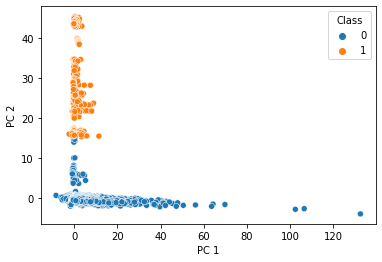

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
pipe = Pipeline([('scaler', StandardScaler()),
                 ('reducer', PCA(n_components=2))])

# Fit the pipeline to poke_df and transform the data
pc = pipe.fit_transform(data1)

# Add the 2 components to poke_cat_df
data1['PC 1'] = pc[:, 0]
data1['PC 2'] = pc[:, 1]

# Use the Legendary feature to color the PC 1 vs PC 2 scatterplot
sns.scatterplot(data=data1, 
                x='PC 1', y='PC 2', hue='Class')
plt.show()

In [20]:
data=pd.read_csv('creditcard.csv')
data1=data
y = data['Class']

X = data.drop('Class', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


# Build the pipeline
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reducer', PCA(n_components=2)),
        ('classifier', RandomForestClassifier(random_state=0))])

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# Score the accuracy on the test set
accuracy = pipe.score(X_test, y_test)

# Prints the explained variance ratio and accuracy
print(pipe.steps[1][1].explained_variance_ratio_)
print('{0:.5%} test set accuracy'.format(accuracy))

[0.06434684 0.05606677]
99.82327% test set accuracy


In [32]:
# Let PCA select 90% of the variance
pipe = Pipeline([('scaler', StandardScaler()),
        		 ('reducer', PCA(n_components=0.90))])

# Fit the pipe to the data
pipe.fit(data1)

print('{} components selected with 90% of the variance'.format(len(pipe.steps[1][1].components_)))
# Let PCA select 90% of the variance
pipe = Pipeline([('scaler', StandardScaler()),
        		 ('reducer', PCA(n_components=0.80))])

# Fit the pipe to the data
pipe.fit(data1)

print('{} components selected with 80% of the variance'.format(len(pipe.steps[1][1].components_)))


26 components selected with 90% of the variance
23 components selected with 80% of the variance


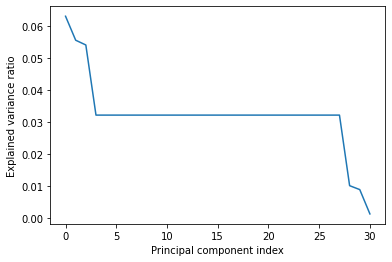

In [35]:
# Pipeline a scaler and pca selecting 10 components
pipe = Pipeline([('scaler', StandardScaler()),
        		 ('reducer', PCA(n_components=31))])

# Fit the pipe to the data
pipe.fit(data1)

# Plot the explained variance ratio
plt.plot(pipe.steps[1][1].explained_variance_ratio_)

plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.show()



With all components (31) you explain all the variance 

# study about PCA and images